In [1]:
import json
import pandas as pd
import os

df = pd.DataFrame()
for dirname, _, filenames in os.walk('../data/27/'):
    for filename in filenames:
        data = {}
        with open(os.path.join(dirname, filename),'r') as file:
            d = json.loads(file.read())
        data['date'] = d['Indices']['NDVI']['Serie Processada']['Data']
        data['indices'] = d['Indices']['NDVI']['Serie Processada']['Indice']
        part = pd.DataFrame(data)
        part['date'] = pd.to_datetime(part['date'], format='%Y-%m-%d')
        print(os.path.join(dirname, filename))
        df = pd.concat([df, part])
df.head(10)

../data/27/2014-2015.json
../data/27/2016-2017.json
../data/27/2018-2019.json
../data/27/2015-2016.json
../data/27/2017-2018.json


,date,indices
0,2014-07-04,0.515106
1,2014-07-12,0.456973
2,2014-07-20,0.395650
3,2014-07-28,0.359355
4,2014-08-05,0.345079
5,2014-08-13,0.338564
6,2014-08-21,0.328624
7,2014-08-29,0.313193
8,2014-09-06,0.297851
9,2014-09-14,0.289836


In [2]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df.set_index('date')
df = df.groupby(df.index).mean()
df = df.asfreq("W",method='backfill')
df = df.sort_index()
df.head(10)

,indices
date,
2014-07-06,0.456973
2014-07-13,0.395650
2014-07-20,0.395650
2014-07-27,0.359355
2014-08-03,0.345079
2014-08-10,0.338564
2014-08-17,0.328624
2014-08-24,0.313193
2014-08-31,0.297851


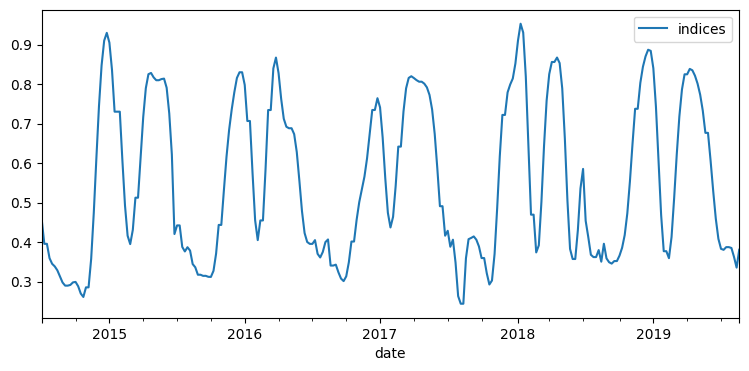

In [3]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(9, 4))
df['indices'].plot(ax=ax, label='indices')
ax.legend()

In [4]:
from datetime import datetime

steps=10
X_train = df.loc[:datetime.strptime('2019-02-20', "%Y-%m-%d")]
X_test = df.loc[datetime.strptime('2019-02-20', "%Y-%m-%d"):datetime.strptime('2019-05-30', "%Y-%m-%d")]

In [5]:
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
auto = auto_arima(
    X_train['indices'],
    seasonal=True,
    stationary=True,
    trace=True, 
    error_action='ignore', 
    suppress_warnings=True
)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-813.047, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-90.177, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-660.135, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-367.447, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=428.198, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-782.750, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-814.448, Time=0.17 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-752.407, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-813.863, Time=0.10 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-812.745, Time=0.26 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-814.703, Time=0.16 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=-812.787, Time=0.14 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=-810.706, Time=0.18 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-785.148, Time=0.02 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0

In [6]:
sarima = SARIMAX(X_train['indices'],order=auto.order,seasonal_order=(1,2,1,8),freq='W',enforce_stationarity=True)
model = sarima.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.01273D-01    |proj g|=  2.87604D+00

At iterate    5    f= -9.48281D-01    |proj g|=  1.95900D+00


 This problem is unconstrained.



At iterate   10    f= -1.10919D+00    |proj g|=  4.03590D-01

At iterate   15    f= -1.12928D+00    |proj g|=  2.25739D+00

At iterate   20    f= -1.27852D+00    |proj g|=  4.68671D-01

At iterate   25    f= -1.27983D+00    |proj g|=  3.00763D-01

At iterate   30    f= -1.28617D+00    |proj g|=  3.31420D-02

At iterate   35    f= -1.28826D+00    |proj g|=  1.79463D-02

At iterate   40    f= -1.28841D+00    |proj g|=  6.89129D-02

At iterate   45    f= -1.28999D+00    |proj g|=  4.72506D-02

At iterate   50    f= -1.29082D+00    |proj g|=  6.39328D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     58   

/home/pedro/workspace/POP-backend/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [7]:
forecast = model.get_forecast(steps=len(X_test))
print(type(forecast))
forecast = pd.DataFrame(forecast.predicted_mean)
forecast.head(10)

<class 'statsmodels.tsa.statespace.mlemodel.PredictionResultsWrapper'>


,predicted_mean
2019-02-24,0.388412
2019-03-03,0.430057
2019-03-10,0.458475
2019-03-17,0.432190
2019-03-24,0.445698
2019-03-31,0.472746
2019-04-07,0.538578
2019-04-14,0.584155
2019-04-21,0.634647
2019-04-28,0.663318


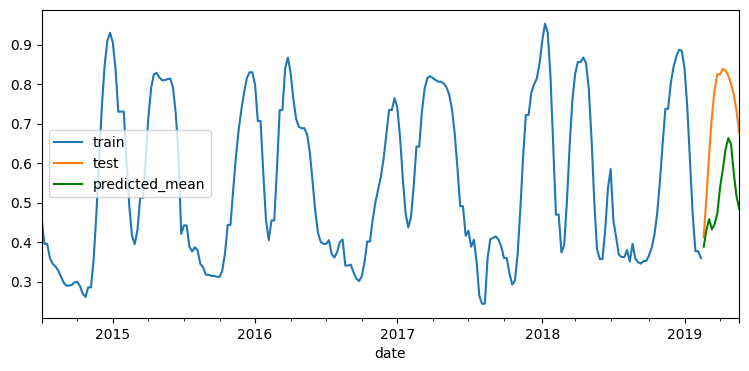

In [8]:
fig, ax=plt.subplots(figsize=(9, 4))
X_train['indices'].plot(ax=ax, label='train')
X_test['indices'].plot(ax=ax, label='test')
forecast.plot(ax=ax, label='predictions', color='green')
ax.legend()

In [9]:
import joblib

joblib.dump(model,'../model/27.h5')

['../model/27.h5']

In [10]:
from cassandra.cluster import Cluster
import uuid

cluster = Cluster(['localhost'])
session = cluster.connect()

keyspace_query = "SELECT keyspace_name FROM system_schema.keyspaces WHERE keyspace_name = 'prediction'"
keyspace_exists = session.execute(keyspace_query).one()

if not keyspace_exists:
    create_keyspace_query = """
        CREATE KEYSPACE IF NOT EXISTS prediction
        WITH replication = {'class':'SimpleStrategy', 'replication_factor': 1}
    """
    session.execute(create_keyspace_query)

session.set_keyspace("prediction")

table_query = "SELECT table_name FROM system_schema.tables WHERE keyspace_name = 'prediction' AND table_name = 'data_series'"
table_exists = session.execute(table_query).one()

if not table_exists:
    create_table_query = """
        CREATE TABLE data_series (
            id_municipio INT,
            data_id UUID,
            valor_indice FLOAT,
            data TEXT,
            PRIMARY KEY (id_municipio, data_id)
        ) WITH CLUSTERING ORDER BY (data_id ASC);
    """
    session.execute(create_table_query)
session.shutdown()
cluster.shutdown()

In [11]:

cluster = Cluster(['localhost'])
session = cluster.connect('prediction')
for i in df.iterrows():
    query = "INSERT INTO data_series (data_id, id_municipio, valor_indice, data) VALUES (%s,%s, %s, %s)"
    session.execute(query, (uuid.uuid4(), 27, i[1]['indices'], f'{i[0].year}-{i[0].month}-{i[0].day}'))
session.shutdown()
cluster.shutdown()

SyntaxException: <Error from server: code=2000 [Syntax error in CQL query] message="line 1:142 no viable alternative at input '-07' (...(5e3e65c3-2358-4fd1-bed8-7382a8aa3e02,27, 0.45697265488151834, 2014[-07]...)">